In [1]:
# means that my matplotlib graphs will be included in the notebook, next to the code
%matplotlib inline

import os

import math
import astropy
import random
import numpy as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u

from hetdex_tools.get_spec import get_spectra
from hetdex_api.config import HDRconfig
from hetdex_api.detections import Detections
from hetdex_api.elixer_widget_cls import ElixerWidget

In [2]:
# not sure why the code below is here, it was in the Detections database and API notebook
# https://github.com/HETDEX/hetdex_api/blob/master/notebooks/api-notebooks/03-Detections_Database_and_API.ipynb

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Opens the catalogs and turns them into dataframes

I like to open both catalogs separately since they are both big (HDR3 especially!)

In [4]:
# Opening HDR3 detections catalog  ** double check this <-- statement ** and converting it into a pandas DF
# HDR3 is detections HETDEX found
HDR_source_cat = fits.open('/home/jovyan/Hobby-Eberly-Telesco/hdr3/catalogs/source_catalog_3.0.1.fits', memmap = True)
HDR3_data = HDR_source_cat[1].data
HDR3_DF = pd.DataFrame(HDR3_data, columns=HDR3_data.columns.names)

In [6]:
# Opening H20 NEP catalog and converting it into a pandas DF
# H20 is stricly photometry sources
H20_NEP_catalog = fits.open('H20_NEP_VIRUS_OVERLAP_CAT_10_2021.fits', memmap = True)
H20_NEP_data = H20_NEP_catalog[1].data
H20_NEP_DF = pd.DataFrame(H20_NEP_data, columns=H20_NEP_data.columns.names)

In [7]:
# Columns we will then take from the entire data set (it was huge so we needed to determine what we wanted to look at specifically).
# As the name suggests, these are the ones that are useful to us!
useful_hdr3_cols = ['source_id', 'detectid',  'selected_det', 'ra_mean', 'dec_mean', 'fwhm', 'shotid', 'field',  'ra', 'dec', 'wave', 'wave_err', 'flux', 'flux_err', 'sn', 'sn_err', 'chi2', 'chi2_err',
'linewidth', 'linewidth_err', 'plya_classification', 'z_hetdex', 'z_hetdex_conf', 'combined_plae']

# For now, the only useful columns for us in H20 NEP is RA and DEC.
useful_h20nep_cols = ['RA_MODELING', 'DEC_MODELING', 'VALID_SOURCE_MODELING']

# From the original DF, taking the useful columns
reduced_hdr3_df = HDR3_DF.loc[:, useful_hdr3_cols]
reduced_h20nep_df = H20_NEP_DF.loc[:, useful_h20nep_cols]

### Cleaning up the data

In [8]:
# Removing data from before 2017 because it isn't good (not useful to us)
# No need to do this for H20 NEP
removed_bad_shots_hdr3_df = reduced_hdr3_df[reduced_hdr3_df.shotid.values >= 20180000000]

### Filtering data. For HDR3 we use a signal to noise greater than 6.5 and for H20 NEP we check if the VALID_SOURCE_MODELING is true

In [9]:
# This will give high confidence detections. Something we would want to do also. What is sn threshold that Valentina's code is having trouble with.
# Reason why, we want high-confidence Lya. If we are very confident sn and another filter, then that's what we consider high-conf lya.
# Once noise and high-confidence sample. We can start exanping on valentina's code and do our own stuff
hdr3_signal_to_noise_interval = removed_bad_shots_hdr3_df[removed_bad_shots_hdr3_df['sn'] > 6.5]

# For now, no need to specify a field. But once trained, we want to run this for the NEP field!
# The VALID_SOURCE_MODELING column which just tells us that the model was able to converge and get fluxes from the source
# False valid source modeling means that the model used to measure the fluxes failed somehow so we cannot use that galaxy reliably
# We want the true ones since we know the model was able to find a galaxy and we can use that for 
# our imaging counterpart identification (ie: to use these galaxy to check if there is a galaxy at our new extraction coordinate)
h20_valid_source_check = reduced_h20nep_df[reduced_h20nep_df['VALID_SOURCE_MODELING'] == True]

## Making two skycoord objects for both catalogs
We do this (instead of directly looking at the dataframes cause when we exract we get fibers from nearby as well. We don't want that.

In [12]:
hdr3_skycoords = SkyCoord(hdr3_signal_to_noise_interval['ra'] * u.deg, hdr3_signal_to_noise_interval['dec'] * u.deg)
h20_skycoords = SkyCoord(h20_valid_source_check['RA_MODELING'] * u.deg, h20_valid_source_check['DEC_MODELING'] * u.deg)

In [18]:
# Getting a random coordinate from the h20 catalog. I didn't get from the hdr3 catalog 
# because the hdr3 one is so much bigger, so it could happen where we dont have imaging overlap
random_coord = h20_skycoords[random.randint(0, h20_skycoords.size)]
# Creating an offseted skycoord
offset_skycoord = random_coord.directional_offset_by(200 * u.arcsec, 200 * u.arcsec)

In [19]:
# Creating two variables holding the separation of both catalogs, returns angles
sep_hdr3 = offset_skycoord.separation(hdr3_skycoord)
sep_h20 = offset_skycoord.separation(h20_skycoord)

In [20]:
# Checking if the separation is less than 1.2 arcseconds (arbitrary value)
check_hdr3 = (sep_hdr3 < 1.2 * u.arcsec)
check_h20 = (sep_h20 < 1.2 * u.arcsec)

In [21]:
# If there is a true value in any of the checks, we need to find a new source because it means there was a close match
if (True in check_hdr3) or (True in check_h20):
    print('need to change source')
else:
    # we extract!!
    print('extract')
    extraction = get_spectra(offset_skycoord)

[INFO - 2022-10-21 05:03:47,684] Finding shots of interest


extract


[INFO - 2022-10-21 05:03:53,669] Number of shots of interest: 4
[INFO - 2022-10-21 05:03:53,671] Extracting 4 sources
[INFO - 2022-10-21 05:03:53,931] Working on shot: 20210611013
[INFO - 2022-10-21 05:03:53,931] Working on shot: 20210612014
[INFO - 2022-10-21 05:03:53,942] Working on shot: 20210616018
[INFO - 2022-10-21 05:03:53,956] Working on shot: 20210708012
[INFO - 2022-10-21 05:03:57,668] Extracting 1
[INFO - 2022-10-21 05:03:59,067] Extraction of sources completed in 0.09 minutes.
[INFO - 2022-10-21 05:03:59,146] Retrieved 1 spectra.


0 means we change offset or another random coordinate

1 great! Makes our job easier, we have noise spectrum

2 or more, what do we do? Bounce off ideas. "Weighted stacking" might be an option! However might not be ideal for comparing to real data.

In [22]:
extraction

ID,shotid,wavelength,spec,spec_err,apcor,flag,gal_flag,amp_flag,meteor_flag
,,Angstrom,1e-17 erg / (Angstrom cm2 s),1e-17 erg / (Angstrom cm2 s),,,,,
int64,int64,float64[1036],float64[1036],float64[1036],float64[1036],int64,int64,int64,int64
1,20210616018,3470.0 .. 5540.0,0.3770250262191068 .. -0.20082867624151654,6.411295200559231 .. 1.7998494377122174,0.9283284196964372 .. 0.9335820640672942,1,1,1,1


In [28]:
extraction['wavelength'].shape

(1, 1036)

In [31]:
%matplotlib inline

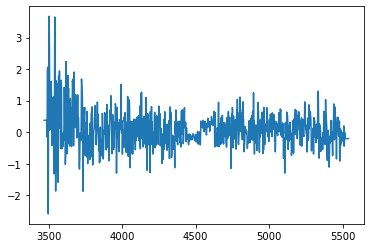

In [32]:
plt.plot(extraction['wavelength'][0], extraction['spec'][0])

## Question: So now do I just put this in a for loop? What do I do now that I have one noise spectrum?

(Function) While loop over 100 random coordinates. Basically repeat this 100 times and then extract. 

Think about how to save noise spectra. A lot of options (numpy, pandas (empty DF, append spec as a column, and transpose so its all rows)).

Once spectrum, check length of table. If 0 no fiber coverage, then need to change things around to get a spectrum. No spectrum means wasn't able to get fiber.

## NOTES

We want no source. This catalog has HETDEX detections one. 

    Want to make sure:
        1.No hetdection detec
        
        2. No imaging counterpart. Do some cross-matching. Gives us a 0 and THEN we extract. Want to extract in basically empty space. Start with 100. 
        
            Coordinates still. Trying to see if no match with the .fits file.

Start with detection. One approach was fits file with coordinates. 

Or 

Use this but expand upon it. Find RA and DEC of each shot. And randomly extract.

    delta ra and delta dec. Double check if is there a source there. 
    
For noise sample, no need to run through valentina's code. Only focus on High-z after filtering through Valentina's code.

Once we have noise sample.

Run through valentina's code. Hopefully it detects them all as high-z. Cause neither low-z or star.

Two skycoords. Check coordinates to see if HETDEX detection is there. Compare minimum separation. If the difference is smaller than 3 arcseconds. Then there is a source there, so do not extract there.